In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import pandas as pd

In [47]:
# Define transformations to apply to the data
transform = transforms.ToTensor()

# Load the CIFAR dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [48]:
torch.manual_seed(4)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

In [49]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt)**self.gamma * BCE_loss
        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

In [50]:
class CifarModel(nn.Module):
  def __init__(self, input, hidden_layer1, hidden_layer2, output):
        super(CifarModel, self).__init__()
        self.fc1 = nn.Linear(input, hidden_layer1)
        self.fc2 = nn.Linear(hidden_layer1, hidden_layer2)
        self.out = nn.Linear(hidden_layer2, output)

  def forward(self, x):
      x = torch.relu(self.fc1(x))
      x = torch.relu(self.fc2(x))
      x = torch.relu(self.out(x))
      return x

In [51]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
from IPython.display import display

cifarModel = CifarModel(3072, 512, 256, 10).to(torch.device('cuda'))

criterion = FocalLoss()
optimizer = torch.optim.Adam(cifarModel.parameters(), lr=0.00001)

losses = []
accuracies = []
precisions_micro = []
recalls_micro = []
f1_scores_micro = []
precisions_macro = []
recalls_macro = []
f1_scores_macro = []
precisions_weighted = []
recalls_weighted = []
f1_scores_weighted = []

epoch = 100

for i in range(epoch):
  curr_loss = 0.0
  y_true = []
  y_pred = []

  for j, data in enumerate(train_loader):
    input, output = data[0].to(torch.device('cuda')), data[1].to(torch.device('cuda'))
    input = input.reshape(50, -1)

    optimizer.zero_grad()

    pred_out = cifarModel.forward(input)
    loss = criterion(pred_out, output)

    loss.backward()
    optimizer.step()

    curr_loss += loss.item()
    y_true += output.tolist()
    y_pred += torch.argmax(pred_out, dim=1).tolist()

  loss_avg = curr_loss / len(train_loader)
  losses.append(loss_avg)

  acc = accuracy_score(y_true, y_pred)
  accuracies.append(acc*100)

  precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(y_true, y_pred, average='micro', zero_division=1)
  precisions_micro.append(precision_micro)
  recalls_micro.append(recall_micro)
  f1_scores_micro.append(f1_micro)

  precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=1)
  precisions_macro.append(precision_macro)
  recalls_macro.append(recall_macro)
  f1_scores_macro.append(f1_macro)

  precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=1)
  precisions_weighted.append(precision_weighted)
  recalls_weighted.append(recall_weighted)
  f1_scores_weighted.append(f1_weighted)
  print(f'epoch: {i:2}  loss: {loss_avg}')



perf_metrics = {
    'loss': losses,
    'accuracy': accuracies,
    'precision_micro': precisions_micro,
    'recall_micro': recalls_micro,
    'f1_micro': f1_scores_micro,
    'precision_macro': precisions_macro,
    'recall_macro': recalls_macro,
    'f1_macro': f1_scores_macro,
    'precision_weighted': precisions_weighted,
    'recall_weighted': recalls_weighted,
    'f1_weighted': f1_scores_weighted
}

perf_metrics_df = pd.DataFrame(perf_metrics)
display(perf_metrics_df)



epoch:  0  loss: 1.700968930363655
epoch:  1  loss: 1.555749872803688
epoch:  2  loss: 1.5140834943056107
epoch:  3  loss: 1.4895096416473388
epoch:  4  loss: 1.4512084027528762
epoch:  5  loss: 1.4172058469057083
epoch:  6  loss: 1.3929166922569274
epoch:  7  loss: 1.3721869486570357
epoch:  8  loss: 1.3539327210783958
epoch:  9  loss: 1.338582332134247
epoch: 10  loss: 1.324171062529087
epoch: 11  loss: 1.3103296773433686
epoch: 12  loss: 1.2975282953977585
epoch: 13  loss: 1.2865983999967574
epoch: 14  loss: 1.275854957818985
epoch: 15  loss: 1.26613978856802
epoch: 16  loss: 1.2578339701890946
epoch: 17  loss: 1.2496035254597664
epoch: 18  loss: 1.2425754835009575
epoch: 19  loss: 1.2346082758307457
epoch: 20  loss: 1.2282421610951424
epoch: 21  loss: 1.2217530051469803
epoch: 22  loss: 1.2157480857372285
epoch: 23  loss: 1.2095397382378579
epoch: 24  loss: 1.2034942786693572
epoch: 25  loss: 1.1976610889434816
epoch: 26  loss: 1.1921473007798196
epoch: 27  loss: 1.1869457440972329

,loss,accuracy,precision_micro,recall_micro,f1_micro,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted
0,1.700969,24.644,0.24644,0.24644,0.24644,0.483673,0.24644,0.189247,0.483673,0.24644,0.189247
1,1.555750,31.396,0.31396,0.31396,0.31396,0.523794,0.31396,0.259689,0.523794,0.31396,0.259689
2,1.514083,33.048,0.33048,0.33048,0.33048,0.536352,0.33048,0.273575,0.536352,0.33048,0.273575
3,1.489510,34.106,0.34106,0.34106,0.34106,0.544453,0.34106,0.282365,0.544453,0.34106,0.282365
4,1.451208,35.430,0.35430,0.35430,0.35430,0.478967,0.35430,0.308935,0.478967,0.35430,0.308935
...,...,...,...,...,...,...,...,...,...,...,...
95,0.967373,54.866,0.54866,0.54866,0.54866,0.646418,0.54866,0.489788,0.646418,0.54866,0.489788
96,0.965133,54.974,0.54974,0.54974,0.54974,0.647570,0.54974,0.490855,0.647570,0.54974,0.490855
97,0.963121,55.012,0.55012,0.55012,0.55012,0.647873,0.55012,0.491173,0.647873,0.55012,0.491173
98,0.960420,55.100,0.55100,0.55100,0.55100,0.648330,0.55100,0.491910,0.648330,0.55100,0.491910


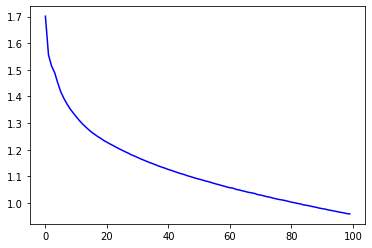

In [52]:
plt.plot(range(epoch), losses, 'b')

In [53]:
correct = 0
total = 0

target_out = []
pred_out = []
with torch.no_grad():
    for (i, data) in enumerate(test_loader):
        images, labels = data[0].to(torch.device('cuda')), data[1].to(torch.device('cuda'))
        # Predict the class of the image
        images = images.reshape(100, -1)
        outputs = cifarModel.forward(images)
        _, predicted = torch.max(outputs.data, 1)

        pred_out += predicted.tolist()
        target_out += labels.tolist()


loss_avg = curr_loss / len(train_loader)

acc = accuracy_score(y_true, y_pred)

precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(y_true, y_pred, average='micro', zero_division=1)


precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=1)


precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=1)


perf_metrics = {
    'loss': [loss_avg],
    'accuracy': [acc*100],
    'precision_micro': [precision_micro*100],
    'recall_micro': [recall_micro*100],
    'f1_micro': [f1_micro*100],
    'precision_macro': [precision_macro*100],
    'recall_macro': [recall_macro*100],
    'f1_macro': [f1_macro*100],
    'precision_weighted': [precision_weighted*100],
    'recall_weighted': [recall_weighted*100],
    'f1_weighted': [f1_weighted*100]
}

perf_metrics_df = pd.DataFrame(perf_metrics)
display(perf_metrics_df)


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,loss,accuracy,precision_micro,recall_micro,f1_micro,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted
0,0.95912,55.138,55.138,55.138,55.138,44.873603,55.138,49.219981,44.873603,55.138,49.219981
